# Experiment for k_latest_snapshot

## Setup

Firstly, the needed packages are imported,

In [2]:
import time
import os
import copy

import matplotlib.pyplot as plt
import tikzplotlib

from os import path

from IPython.display import Markdown as md
from functools import reduce

from fca.api_models import Context, IncLattice
from transform_orders_to_formal_context import generate_csv_by_resort


We setup the dataset directory,

In [3]:
# Modify this with whatever path you have your dataset
the_path = os.getcwd()
os.chdir(f'{the_path}/..')
os.getcwd()

'/home/ramshell/Documents/phd/valraiso/dataset'

We define helper functions for readability


In [4]:
def create_snapshot_for_resort(csv_file_name_template, resort, from_idx=0, maximum_rows=100000, min_support=0.1, min_confidence=.3,
                               rewrite=False):
    csv_file_name = csv_file_name_template.format(resort)

    # if rewrite or not path.exists(csv_file_name):
    generate_csv_by_resort(resort=resort, from_idx=from_idx, maximum_rows=maximum_rows,
                        csv_file=csv_file_name_template,
                        min_support=min_support, min_confidence=min_confidence)
    
    ctx = Context.from_csv(csv_file_name)
    return ctx

def generate_lattice(size, csv_file_name_template, resort, min_support=1, min_confidence=1, offset=0):
    latest_k_orders_ctx = create_snapshot_for_resort(csv_file_name_template, resort, from_idx=offset,
                                                     maximum_rows=size, min_support=min_support,
                                                     min_confidence=min_confidence, rewrite=True)
    return IncLattice(latest_k_orders_ctx)

def lattices_report(l1, l2, lm, l1_name='L', l2_name='L_s', lm_name='L_m'):
    return md(lattice_report(l1, l1_name) + "\n" + lattice_report(l2, l2_name) + "\n" + lattice_report(lm, lm_name))

def lattice_report(l, name="L"):
    max_g_prime = reduce(lambda x, y: x if x > y else y,
                         (reduce(lambda x, y: x + (1 if y else 0), values, 0) for values in l.ctx.I),
                         0)

    return f"$|{name}| = {len(l.concepts)}$, $|G| = {len(l.ctx.G)}$, $|M| = {len(l.ctx.M)}$, " \
           f"$max(|g'|) = {max_g_prime}$"

# Time Experiment

First, we create a wrapper to measure the elapsed time for functions

In [4]:
def measure_time(f):
    def wrap(*args, **kwargs):
        ts = time.time()
        res = f(*args, **kwargs)
        tf = time.time()
        elapsed_time = tf - ts
        print(f'{f.__name__} execution_time: {elapsed_time*1000}ms')
        return res
    return wrap

## Add the rows of Ls to L vs Merge

Then, a function to merge both snapshots.

In [5]:
def merge_by_incrementally_adding_rows(l1, l2):
    fst_ctx = l1.ctx
    snd_ctx = l2.ctx
    if len(fst_ctx.O) < len(snd_ctx.O):
        fst_ctx, snd_ctx = snd_ctx, fst_ctx
        l1, l2 = l2, l1
    
    copy_l = IncLattice.copy(l1)  # O(|L|)
    # since they might have a different set of attributes
    add_attributes(copy_l, l2)
    attr_idx = get_attribute_ids(copy_l.ctx)
    for i, g in enumerate(snd_ctx.O):
        attrs = get_attributes(i, snd_ctx, attr_idx)
        copy_l.add_intent(g, attrs)
    
    return copy_l

def add_attributes(l1, l2):
    attributes_1 = set(l1.ctx.A)
    attributes_2 = set(l2.ctx.A)
    new_attributes = attributes_2.difference(attributes_1)
    for a in new_attributes:
        l1.add_attribute(a)

def get_attributes(i: int, ctx: Context, ids: dict):
    attrs = []
    for j, m in enumerate(ctx.A):
        if ctx.I[i][j]:
            attrs.append(ids[m])
    return attrs

def get_attribute_ids(ctx: Context):
    attr_idx = dict()
    for j, m in enumerate(ctx.A):
        attr_idx[m] = j
    return attr_idx

Define the function to do the merge

In [8]:
def merge_by_using_both_calculated_lattices(l1, l2):
    return l1.merge_concepts(l2)

Start the experiments

### Let us consider the rate 1:0.5

In [13]:
latest_k_orders_l = generate_lattice(500, 'experiment_latest_k_orders_ctx_resort_{}.csv', 362, min_support=0.01, min_confidence=0.3)
orders_snapshot_l = generate_lattice(300, 'experiment_snapshot_orders_ctx_resort_{}.csv', 362, min_support=0.1, min_confidence=0.2, offset=500 + 200)

%time l1 = merge_by_incrementally_adding_rows(latest_k_orders_l, orders_snapshot_l)
%time l2 = merge_by_using_both_calculated_lattices(latest_k_orders_l, orders_snapshot_l)
assert len(l1.concepts) == len(l2)
lattices_report(latest_k_orders_l, orders_snapshot_l, l1)

CPU times: user 511 ms, sys: 0 ns, total: 511 ms
Wall time: 511 ms
CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 112 ms


$|L| = 118$, $|G| = 503$, $|M| = 44$, $max(|g'|) = 9$
$|L_s| = 75$, $|G| = 302$, $|M| = 36$, $max(|g'|) = 9$
$|L_m| = 139$, $|G| = 805$, $|M| = 49$, $max(|g'|) = 9$

In [14]:
latest_k_orders_l = generate_lattice(2000, 'experiment_latest_k_orders_ctx_resort_{}.csv', 596)
orders_snapshot_l = generate_lattice(1000, 'experiment_snapshot_orders_ctx_resort_{}.csv', 596, offset=2000 + 400)


%time l1 = merge_by_incrementally_adding_rows(latest_k_orders_l, orders_snapshot_l)
%time l2 = merge_by_using_both_calculated_lattices(latest_k_orders_l, orders_snapshot_l)
assert len(l1.concepts) == len(l2)
lattices_report(latest_k_orders_l, orders_snapshot_l, l1)

/home/ramshell/Documents/phd/valraiso/dataset/src/transform_orders_to_formal_context.py:195: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders = pd.read_csv(orders_file)
/home/ramshell/Documents/phd/valraiso/dataset/src/transform_orders_to_formal_context.py:195: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders = pd.read_csv(orders_file)


CPU times: user 12.7 s, sys: 0 ns, total: 12.7 s
Wall time: 12.7 s
CPU times: user 1.44 s, sys: 14 µs, total: 1.44 s
Wall time: 1.44 s


$|L| = 367$, $|G| = 2130$, $|M| = 59$, $max(|g'|) = 8$
$|L_s| = 162$, $|G| = 1000$, $|M| = 40$, $max(|g'|) = 9$
$|L_m| = 408$, $|G| = 3130$, $|M| = 60$, $max(|g'|) = 9$

In [12]:
latest_k_orders_l = generate_lattice(1000, 'experiment_latest_k_orders_ctx_resort_{}.csv', 125)
orders_snapshot_l = generate_lattice(500, 'experiment_snapshot_orders_ctx_resort_{}.csv', 125, offset=1000 + 400)


%time l1 = merge_by_incrementally_adding_rows(latest_k_orders_l, orders_snapshot_l)
%time l2 = merge_by_using_both_calculated_lattices(latest_k_orders_l, orders_snapshot_l)
assert len(l1.concepts) == len(l2)
lattices_report(latest_k_orders_l, orders_snapshot_l, l1)

/home/ramshell/Documents/phd/valraiso/dataset/src/transform_orders_to_formal_context.py:195: DtypeWarning: Columns (14,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders = pd.read_csv(orders_file)
/home/ramshell/Documents/phd/valraiso/dataset/src/transform_orders_to_formal_context.py:197: DtypeWarning: Columns (10,11,12,13,14,16,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders_esf = pd.read_csv(orders_esf_file)
/home/ramshell/Documents/phd/valraiso/dataset/src/transform_orders_to_formal_context.py:195: DtypeWarning: Columns (14,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders = pd.read_csv(orders_file)
/home/ramshell/Documents/phd/valraiso/dataset/src/transform_orders_to_formal_context.py:197: DtypeWarning: Columns (10,11,12,13,14,16,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders_esf = pd.read_csv(orders_esf_file

CPU times: user 36.4 s, sys: 0 ns, total: 36.4 s
Wall time: 36.4 s
CPU times: user 3.37 s, sys: 7.98 ms, total: 3.38 s
Wall time: 3.37 s


$|L| = 1341$, $|G| = 1937$, $|M| = 70$, $max(|g'|) = 10$
$|L_s| = 847$, $|G| = 985$, $|M| = 72$, $max(|g'|) = 10$
$|L_m| = 1651$, $|G| = 2922$, $|M| = 79$, $max(|g'|) = 10$

In [15]:
latest_k_orders_l = generate_lattice(4000, 'experiment_latest_k_orders_ctx_resort_{}.csv', 308)
orders_snapshot_l = generate_lattice(2000, 'experiment_snapshot_orders_ctx_resort_{}.csv', 308, offset=4000 + 400)


%time l1 = merge_by_incrementally_adding_rows(latest_k_orders_l, orders_snapshot_l)
%time l2 = merge_by_using_both_calculated_lattices(latest_k_orders_l, orders_snapshot_l)
assert len(l1.concepts) == len(l2)
lattices_report(latest_k_orders_l, orders_snapshot_l, l1)

CPU times: user 4min 14s, sys: 0 ns, total: 4min 14s
Wall time: 4min 14s
CPU times: user 6.79 s, sys: 15.9 ms, total: 6.81 s
Wall time: 6.78 s


$|L| = 3272$, $|G| = 6819$, $|M| = 70$, $max(|g'|) = 11$
$|L_s| = 100$, $|G| = 3971$, $|M| = 36$, $max(|g'|) = 7$
$|L_m| = 3305$, $|G| = 10790$, $|M| = 70$, $max(|g'|) = 11$

In [16]:
latest_k_orders_l = generate_lattice(10000, 'experiment_latest_k_orders_ctx_resort_{}.csv', 422)
orders_snapshot_l = generate_lattice(4000, 'experiment_snapshot_orders_ctx_resort_{}.csv', 422, offset=10000 + 400)


%time l1 = merge_by_incrementally_adding_rows(latest_k_orders_l, orders_snapshot_l)
%time l2 = merge_by_using_both_calculated_lattices(latest_k_orders_l, orders_snapshot_l)
assert len(l1.concepts) == len(l2)
lattices_report(latest_k_orders_l, orders_snapshot_l, l1)

/home/ramshell/Documents/phd/valraiso/dataset/src/transform_orders_to_formal_context.py:197: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders_esf = pd.read_csv(orders_esf_file)
/home/ramshell/Documents/phd/valraiso/dataset/src/transform_orders_to_formal_context.py:197: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders_esf = pd.read_csv(orders_esf_file)


CPU times: user 9min 23s, sys: 3.92 ms, total: 9min 23s
Wall time: 9min 23s
CPU times: user 42.1 s, sys: 60.1 ms, total: 42.1 s
Wall time: 42 s


$|L| = 3199$, $|G| = 14326$, $|M| = 82$, $max(|g'|) = 11$
$|L_s| = 393$, $|G| = 4416$, $|M| = 52$, $max(|g'|) = 10$
$|L_m| = 3298$, $|G| = 18742$, $|M| = 84$, $max(|g'|) = 11$

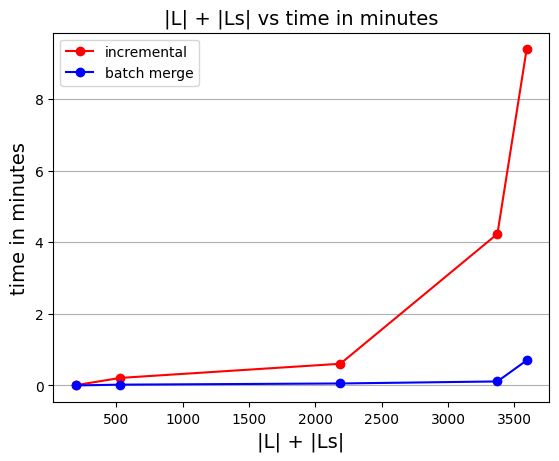

In [26]:
l_plus_ls_size = [118 + 75, 367 + 162, 1341 + 847, 3272 + 100, 3199 + 393]
time_passed = [x/60 for x in [.51, 12.7, 36.4, 4 * 60 + 14, 9 * 60 + 23]]
time_passed_for_merge = [x/60 for x in [.11, 1.4, 3.37, 6.78, 42]]
  
plt.plot(l_plus_ls_size, time_passed, color='red', marker='o', label="incremental")
plt.plot(l_plus_ls_size, time_passed_for_merge, color='blue', marker='o', label="batch merge")
plt.title('|L| + |Ls| vs time in minutes', fontsize=14)
plt.xlabel('|L| + |Ls|', fontsize=14)
plt.ylabel('time in minutes', fontsize=14)
plt.legend(loc="upper left")
plt.grid(axis='y')
tikzplotlib.save("sum_of_param_sizes_vs_minutes.tex")
plt.show()

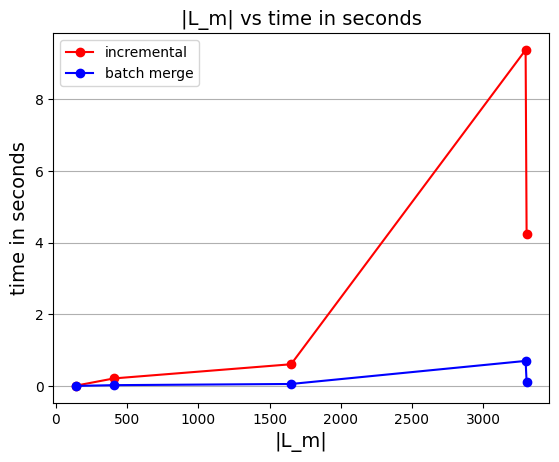

In [28]:
lm_size = [139, 408, 1651, 3298, 3305]
time_passed = [x/60 for x in [.51, 12.7, 36.4, 9 * 60 + 23, 4 * 60 + 14]]
time_passed_for_merge = [x/60 for x in [.11, 1.4, 3.37, 42, 6.78]]
  
plt.plot(lm_size, time_passed, color='red', marker='o', label="incremental")
plt.plot(lm_size, time_passed_for_merge, color='blue', marker='o', label="batch merge")
plt.title('|L_m| vs time in seconds', fontsize=14)
plt.xlabel('|L_m|', fontsize=14)
plt.ylabel('time in seconds', fontsize=14)
plt.legend(loc="upper left")
plt.grid(axis='y')
tikzplotlib.save("size_of_lm_vs_minutes.tex")
plt.show()

### Let us consider the rate 1:1

In [49]:
latest_k_orders_l = generate_lattice(500, 'experiment_latest_k_orders_ctx_resort_{}.csv', 362, min_support=0.01, min_confidence=0.3)
orders_snapshot_l = generate_lattice(500, 'experiment_snapshot_orders_ctx_resort_{}.csv', 362, min_support=0.1, min_confidence=0.2, offset=500 + 200)

%time l1 = merge_by_incrementally_adding_rows(latest_k_orders_l, orders_snapshot_l)
%time l2 = merge_by_using_both_calculated_lattices(latest_k_orders_l, orders_snapshot_l)
assert len(l1.concepts) == len(l2)
lattices_report(latest_k_orders_l, orders_snapshot_l, l1)

CPU times: user 1.81 s, sys: 0 ns, total: 1.81 s
Wall time: 1.81 s
CPU times: user 230 ms, sys: 1 µs, total: 230 ms
Wall time: 229 ms


$|L| = 118$, $|G| = 503$, $|M| = 44$, $max(|g'|) = 9$
$|L_s| = 85$, $|G| = 502$, $|M| = 40$, $max(|g'|) = 9$
$|L_m| = 142$, $|G| = 1005$, $|M| = 51$, $max(|g'|) = 9$

In [51]:
latest_k_orders_l = generate_lattice(2000, 'experiment_latest_k_orders_ctx_resort_{}.csv', 596)
orders_snapshot_l = generate_lattice(2000, 'experiment_snapshot_orders_ctx_resort_{}.csv', 596, offset=2000 + 400)


%time l1 = merge_by_incrementally_adding_rows(latest_k_orders_l, orders_snapshot_l)
%time l2 = merge_by_using_both_calculated_lattices(latest_k_orders_l, orders_snapshot_l)
assert len(l1.concepts) == len(l2)
lattices_report(latest_k_orders_l, orders_snapshot_l, l1)

/home/ramshell/Documents/phd/valraiso/dataset/src/transform_orders_to_formal_context.py:195: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders = pd.read_csv(orders_file)
/home/ramshell/Documents/phd/valraiso/dataset/src/transform_orders_to_formal_context.py:195: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders = pd.read_csv(orders_file)


CPU times: user 1min 1s, sys: 0 ns, total: 1min 1s
Wall time: 1min 1s
CPU times: user 3.86 s, sys: 4 µs, total: 3.86 s
Wall time: 3.85 s


$|L| = 367$, $|G| = 2130$, $|M| = 59$, $max(|g'|) = 8$
$|L_s| = 209$, $|G| = 2000$, $|M| = 44$, $max(|g'|) = 9$
$|L_m| = 428$, $|G| = 4130$, $|M| = 60$, $max(|g'|) = 9$

In [50]:
latest_k_orders_l = generate_lattice(1000, 'experiment_latest_k_orders_ctx_resort_{}.csv', 125)
orders_snapshot_l = generate_lattice(1000, 'experiment_snapshot_orders_ctx_resort_{}.csv', 125, offset=1000 + 400)


%time l1 = merge_by_incrementally_adding_rows(latest_k_orders_l, orders_snapshot_l)
%time l2 = merge_by_using_both_calculated_lattices(latest_k_orders_l, orders_snapshot_l)
assert len(l1.concepts) == len(l2)
lattices_report(latest_k_orders_l, orders_snapshot_l, l1)

/home/ramshell/Documents/phd/valraiso/dataset/src/transform_orders_to_formal_context.py:195: DtypeWarning: Columns (14,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders = pd.read_csv(orders_file)
/home/ramshell/Documents/phd/valraiso/dataset/src/transform_orders_to_formal_context.py:197: DtypeWarning: Columns (10,11,12,13,14,16,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders_esf = pd.read_csv(orders_esf_file)
/home/ramshell/Documents/phd/valraiso/dataset/src/transform_orders_to_formal_context.py:195: DtypeWarning: Columns (14,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders = pd.read_csv(orders_file)
/home/ramshell/Documents/phd/valraiso/dataset/src/transform_orders_to_formal_context.py:197: DtypeWarning: Columns (10,11,12,13,14,16,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders_esf = pd.read_csv(orders_esf_file

CPU times: user 2min 21s, sys: 0 ns, total: 2min 21s
Wall time: 2min 21s
CPU times: user 9.17 s, sys: 4.01 ms, total: 9.17 s
Wall time: 9.14 s


$|L| = 1341$, $|G| = 1937$, $|M| = 70$, $max(|g'|) = 10$
$|L_s| = 1307$, $|G| = 1954$, $|M| = 82$, $max(|g'|) = 10$
$|L_m| = 1964$, $|G| = 3891$, $|M| = 84$, $max(|g'|) = 10$

In [53]:
latest_k_orders_l = generate_lattice(4000, 'experiment_latest_k_orders_ctx_resort_{}.csv', 308)
orders_snapshot_l = generate_lattice(4000, 'experiment_snapshot_orders_ctx_resort_{}.csv', 308, offset=4000 + 400)


%time l1 = merge_by_incrementally_adding_rows(latest_k_orders_l, orders_snapshot_l)
%time l2 = merge_by_using_both_calculated_lattices(latest_k_orders_l, orders_snapshot_l)
assert len(l1.concepts) == len(l2)
lattices_report(latest_k_orders_l, orders_snapshot_l, l1)

CPU times: user 11min 30s, sys: 0 ns, total: 11min 30s
Wall time: 11min 30s
CPU times: user 19.4 s, sys: 39.9 ms, total: 19.4 s
Wall time: 19.3 s


$|L| = 3272$, $|G| = 6819$, $|M| = 70$, $max(|g'|) = 11$
$|L_s| = 432$, $|G| = 5386$, $|M| = 42$, $max(|g'|) = 9$
$|L_m| = 3637$, $|G| = 12205$, $|M| = 71$, $max(|g'|) = 11$

In [54]:
latest_k_orders_l = generate_lattice(10000, 'experiment_latest_k_orders_ctx_resort_{}.csv', 422)
orders_snapshot_l = generate_lattice(10000, 'experiment_snapshot_orders_ctx_resort_{}.csv', 422, offset=10000 + 400)


%time l1 = merge_by_incrementally_adding_rows(latest_k_orders_l, orders_snapshot_l)
%time l2 = merge_by_using_both_calculated_lattices(latest_k_orders_l, orders_snapshot_l)
assert len(l1.concepts) == len(l2)
lattices_report(latest_k_orders_l, orders_snapshot_l, l1)

/home/ramshell/Documents/phd/valraiso/dataset/src/transform_orders_to_formal_context.py:197: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders_esf = pd.read_csv(orders_esf_file)
/home/ramshell/Documents/phd/valraiso/dataset/src/transform_orders_to_formal_context.py:197: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orders_esf = pd.read_csv(orders_esf_file)


CPU times: user 1h 43min 10s, sys: 35.8 ms, total: 1h 43min 10s
Wall time: 1h 43min 10s
CPU times: user 2min 27s, sys: 300 ms, total: 2min 27s
Wall time: 2min 26s


$|L| = 3199$, $|G| = 14326$, $|M| = 82$, $max(|g'|) = 11$
$|L_s| = 605$, $|G| = 11315$, $|M| = 54$, $max(|g'|) = 10$
$|L_m| = 3448$, $|G| = 25641$, $|M| = 84$, $max(|g'|) = 11$

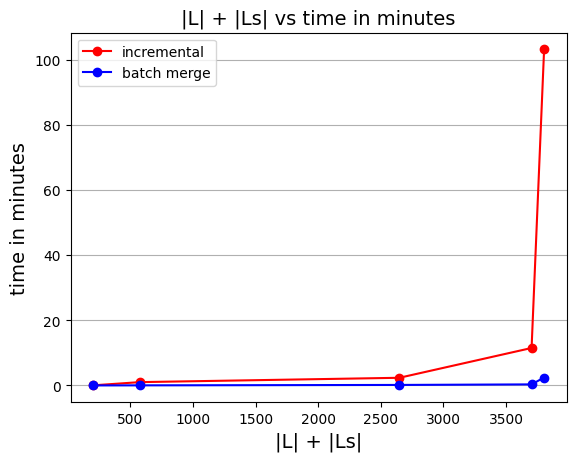

In [25]:
l_plus_ls_size = [118 + 85, 367 + 209, 1341 + 1307, 3272 + 432, 3199 + 605]
time_passed = [x/60 for x in [1.81, 1 * 60 + 1, 2 * 60 + 21, 11 * 60 + 30, 3600 + 43 * 60 + 10]]
time_passed_for_merge = [x/60 for x in [.229, 1.4, 9.14, 19.3, 2 * 60 + 26]]
  
plt.plot(l_plus_ls_size, time_passed, color='red', marker='o', label="incremental")
plt.plot(l_plus_ls_size, time_passed_for_merge, color='blue', marker='o', label="batch merge")
plt.title('|L| + |Ls| vs time in minutes', fontsize=14)
plt.xlabel('|L| + |Ls|', fontsize=14)
plt.ylabel('time in minutes', fontsize=14)
plt.legend(loc="upper left")
plt.grid(axis='y')
tikzplotlib.save("sum_of_param_sizes_vs_minutes_ratio_1_1.tex")
plt.show()

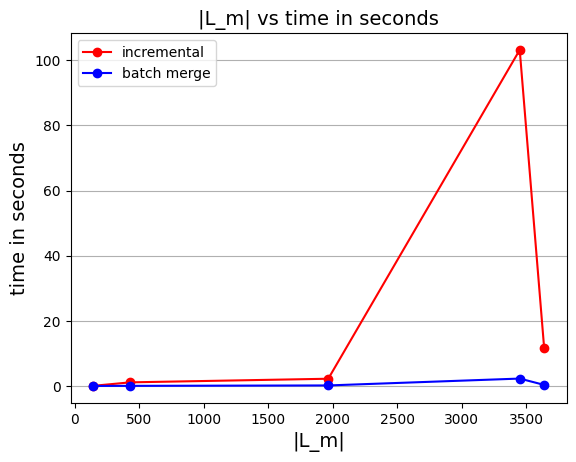

In [24]:
lm_size = [142, 428, 1964, 3448, 3637,]
time_passed = [x/60 for x in [1.81, 1.1 * 60, 2.21 * 60, 3600 + 43 * 60 + 10, 11.3 * 60 + 30]]
time_passed_for_merge = [x/60 for x in [.229, 1.4, 9.14, 2.26 * 60, 19.3]]
  
plt.plot(lm_size, time_passed, color='red', marker='o', label="incremental")
plt.plot(lm_size, time_passed_for_merge, color='blue', marker='o', label="batch merge")
plt.title('|L_m| vs time in seconds', fontsize=14)
plt.xlabel('|L_m|', fontsize=14)
plt.ylabel('time in seconds', fontsize=14)
plt.legend(loc="upper left")
plt.grid(axis='y')
tikzplotlib.save("size_of_lm_vs_minutes_ratio_1_1.tex")
plt.show()